In [1]:
import h5py
import numpy as np
import scipy.io
from keras.utils.io_utils import HDF5Matrix
import matplotlib.pyplot as plt
from PIL import Image as im

E:\program\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import h5py
#load data from NYU Depth V2
#Dataset = scipy.io.loadmat('nyu_depth_v2_labeled')
#splits = scipy.io.loadmat('splits')
f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
#f = h5py.File('splits.mat', 'r')
#print(f.items())
for k, v in f.items():
    print(k,'      ',v)

#refs#        <HDF5 group "/#refs#" (8484 members)>
#subsystem#        <HDF5 group "/#subsystem#" (1 members)>
accelData        <HDF5 dataset "accelData": shape (4, 1449), type "<f4">
depths        <HDF5 dataset "depths": shape (1449, 640, 480), type "<f4">
images        <HDF5 dataset "images": shape (1449, 3, 640, 480), type "|u1">
instances        <HDF5 dataset "instances": shape (1449, 640, 480), type "|u1">
labels        <HDF5 dataset "labels": shape (1449, 640, 480), type "<u2">
names        <HDF5 dataset "names": shape (1, 894), type "|O">
namesToIds        <HDF5 dataset "namesToIds": shape (1, 6), type "<u4">
rawDepthFilenames        <HDF5 dataset "rawDepthFilenames": shape (1, 1449), type "|O">
rawDepths        <HDF5 dataset "rawDepths": shape (1449, 640, 480), type "<f4">
rawRgbFilenames        <HDF5 dataset "rawRgbFilenames": shape (1, 1449), type "|O">
sceneTypes        <HDF5 dataset "sceneTypes": shape (1, 1449), type "|O">
scenes        <HDF5 dataset "scenes": shape (1, 14

In [9]:
set_l = f['labels']
set_d = f['depths']


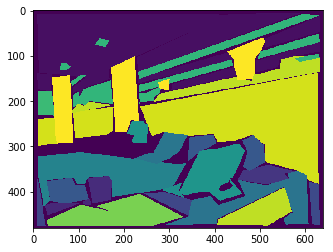

In [45]:
plt.imshow(set_l[111].T)

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy import signal

In [26]:
img11.max()

21

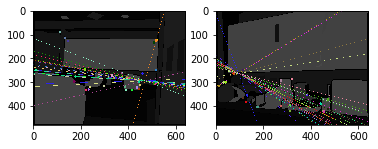

In [46]:
img11 = set_l[9].T
img11 = img11.astype(np.uint8)
img21 = set_l[10].T
img21 = img21.astype(np.uint8)

surf = cv2.xfeatures2d.SURF_create()



# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img11,None)
kp2, des2 = surf.detectAndCompute(img21,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img11,img21,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img21,img11,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()